In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

plt.style.use('dark_background')

def sample(data, labels, num_samples_per_digit):
    sampled_data = []
    sampled_labels = []
    for digit in range(10):
        digit_indices = np.where(labels == digit)[0]
        sampled_indices = np.random.choice(digit_indices, num_samples_per_digit, replace=False)
        sampled_data.append(data[sampled_indices])
        sampled_labels.append(labels[sampled_indices])
    return np.concatenate(sampled_data), np.concatenate(sampled_labels)

# Load / resize images

In [52]:
from tensorflow.keras.datasets import cifar10

# Load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Define how many samples of each digit to include
train_samples_per_class = 500
test_samples_per_class = 50

# Sample the training and testing data
X_train, y_train = sample(X_train, y_train, train_samples_per_class)
X_test, y_test = sample(X_test, y_test, test_samples_per_class)

# Print shapes
print("X_train.shape:", X_train.shape)
print("X_test.shape: ", X_test.shape)

X_train.shape: (9994, 32, 32, 3)
X_test.shape:  (10000, 32, 32, 3)
y_train counts:  [ 758 1221  256  787 3588  170 2088   85  724  317]


In [50]:
y_train

array([[0],
       [0],
       [0],
       ...,
       [9],
       [9],
       [9]], dtype=uint8)

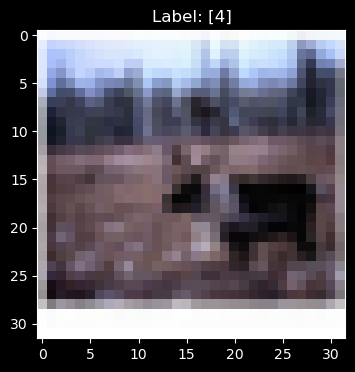

In [6]:
# Display a random image
idx = np.random.randint(0, len(X_train))
plt.figure(figsize=(4, 4))
plt.imshow(X_train[idx])
plt.title(f"Label: {y_train[idx]}")
plt.show()

In [7]:
import tensorflow as tf

# Resize and preprocess the data to match EfficientNetB3 input
X_train = np.array( tf.image.resize(X_train, (224, 224)) )
X_test = np.array( tf.image.resize(X_test, (224, 224)) )

print("X_train.shape:", X_train.shape)
print("X_test.shape: ", X_test.shape)

X_train.shape: (5000, 224, 224, 3)
X_test.shape:  (500, 224, 224, 3)


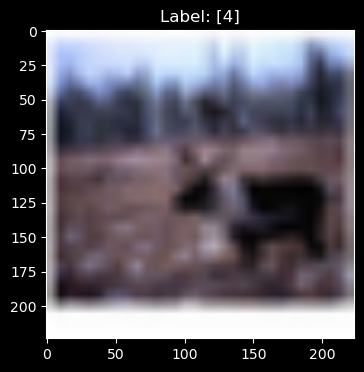

In [8]:
# Display a random image
plt.figure(figsize=(4, 4))
plt.imshow(X_train[idx].astype(int))
plt.title(f"Label: {y_train[idx]}")
plt.show()

# Modeling

## Load Pre-trained Model

Keras applications: https://keras.io/api/applications/

In [9]:
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.applications import MobileNetV2

# Load EfficientNetB3 without top layer
base_model = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Display model summary
#base_model.summary()

## Get pre-trained features

In [10]:
# Extract features using the untrainable EfficientNetB3
X_train_encoded = base_model.predict(X_train, verbose=1)
X_test_encoded = base_model.predict(X_test, verbose=1)

print("X_train_encoded.shape:", X_train_encoded.shape)
print("X_test_encoded.shape: ", X_test_encoded.shape)

157/157 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 947ms/step
X_train_encoded.shape: (5000, 7, 7, 1280)
X_test_encoded.shape:  (500, 7, 7, 1280)


## Create / train simple dense head

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

n_classes  = np.unique(y_train).shape[0]

# Create a classification head
input_encodednput_encoded = Input(shape=X_train_encoded.shape[1:])
x = Flatten()(input_encoded)
x = Dropout(0.5)(x)
outputs = Dense(n_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=input_encoded, outputs=outputs)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 7, 7, 1280)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │         627,210 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 627,210 (2.39 MB)

 Trainable params: 627,210 (2.39 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay, PolynomialDecay

# define training parameters
epochs     = 50
batch_size = 200

optimizer = Adam(
    learning_rate=0.001,
)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=20,          # Stop after 5 epochs without improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

In [22]:
history = model.fit(
    X_train_encoded, y_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_test_encoded, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6105 - loss: 1.7172 - val_accuracy: 0.8960 - val_loss: 0.5138
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9486 - loss: 0.2383 - val_accuracy: 0.9040 - val_loss: 0.4980
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9772 - loss: 0.0662 - val_accuracy: 0.9100 - val_loss: 0.4913
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9930 - loss: 0.0202 - val_accuracy: 0.9140 - val_loss: 0.4561
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9993 - loss: 0.0061 - val_accuracy: 0.9140 - val_loss: 0.4637
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9991 - loss: 0.0054 - val_accuracy: 0.9200 - val_loss: 0.4546
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9999 - loss: 0.0020 - val_accuracy: 0.9120 - val_loss: 0.4479
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9200 - v

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_train_pred = model.predict(X_train_encoded).argmax(axis=1)
y_test_pred  = model.predict(X_test_encoded).argmax(axis=1)

# Confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test  = confusion_matrix(y_test, y_test_pred)

# 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Top-left: Training and Validation Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Top-right: Training and Validation Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Bottom-left: Confusion Matrix (Training)
sns.heatmap(cm_train, annot=True, fmt='d', ax=axes[1, 0], vmin=0, 
            annot_kws={"size": 12}, cmap='nipy_spectral')
axes[1, 0].set_title('Confusion Matrix (Training Data)')
axes[1, 0].set_xlabel('Predicted Label')
axes[1, 0].set_ylabel('True Label')

# Bottom-right: Confusion Matrix (Test)
sns.heatmap(cm_test, annot=True, fmt='d', ax=axes[1, 1], vmin=0, 
            annot_kws={"size": 12}, cmap='nipy_spectral')
axes[1, 1].set_title('Confusion Matrix (Test Data)')
axes[1, 1].set_xlabel('Predicted Label')
axes[1, 1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Print classification report for test data
print("Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred))

## Create combined model

In [24]:
# Define the new input and pass through base_model
combined_input = Input(shape=(224, 224, 3))
x = base_model(combined_input, training=False)

# Now attach the existing classification head
x = model(x)

# Final combined model
combined_model = Model(inputs=combined_input, outputs=x)
combined_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-m (Functional)        │ (None, 7, 7, 1280)          │      53,150,388 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_3 (Functional)            │ (None, 10)                  │         627,210 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,777,598 (205.15 MB)

 Trainable params: 627,210 (2.39 MB)

 Non-trainable params: 53,150,388 (202.75 MB)

In [25]:
np.argmax(combined_model.predict(X_train[:10], verbose=1), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [26]:
y_train[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=uint8)